In [0]:
# Reading data from CSV

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp gdrive/My\ Drive/AI-In-Peer-Assessment/problems_expertiza_merged_gabe.csv .

In [0]:
ls

gdrive/  problems_expertiza_merged_gabe.csv  sample_data/


In [0]:
import numpy as np

# To store data
import pandas as pd

# To use regular expressions
import re

#To load and save data
import pickle

from sklearn.model_selection import train_test_split

In [0]:
reviews = pd.read_csv("problems_expertiza_merged_gabe.csv") 

In [0]:
reviews.head(5)

,TAG,REVIEW
0,0,Great testing plan. They have worked on it ver...
1,0,Test plan is pretty good.
2,0,The test plan is good and covers every details...
3,1,The team has done good job in test plan sectio...
4,1,They have visualization which are some tables ...


In [0]:
data = reviews.filter(["REVIEW","TAG"])

In [0]:
data = data.loc[data.REVIEW.apply(lambda x: not isinstance(x, (float, int)))]

In [0]:
data.head()

,REVIEW,TAG
0,The code seems to be readable and the naming c...,-1
1,The code was written in a clean and readable w...,1
2,Bookings_controller is huge. You should be put...,1
3,The code looks neat and each function is named...,-1
4,The team uses clean ruby practice. The code is...,-1


In [0]:
data['TAG'].value_counts() # 1 for problems, -1 are no problems

1    5585
0    5585
Name: TAG, dtype: int64

In [0]:
train_set, test_set = train_test_split(data, test_size=0.05, random_state=42)

In [0]:
train_reviews = list(train_set["REVIEW"])

In [0]:
train_labels = list(train_set["TAG"])

In [0]:
train_reviews[1],train_labels[1]

('The writeup can be improved to begin with a short description of the project backgound so that anyone reading the writeup can understand what the project is all about.',
 1)

In [0]:
len(train_reviews), len(train_labels)

(14530, 14530)

In [0]:
for i in range(len(train_reviews)):
  train_reviews[i] = re.sub('\d',' ',train_reviews[i]) # Replacing digits by space
  train_reviews[i] = re.sub(r'\s+[a-z][\s$]', ' ',train_reviews[i]) # Removing single characters and spaces alongside
  train_reviews[i] = re.sub(r'\s+', ' ',train_reviews[i]) # Replacing more than one space with a single space

In [0]:
for i in range(len(train_reviews)):
    if 'www.' in train_reviews[i] or 'http:' in train_reviews[i] or 'https:' in train_reviews[i] or '.com' in train_reviews[i]:
        train_reviews[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_reviews[i])
        
        
train_reviews[1:5]

['Yes. The team had bulleted list of tasked items to implement in the Proposed Imports Changes section.',
 'Yes the design doc incorporates all the functionality mentioned in the above link.',
 'They have test on most controllers and the user model',
 'Yes, the team has indeed added test case and made test plan for both the issues that they have resolved.']

In [0]:
# Use Tokenizer to remove punctuations and non-word characters and tokenize the text
import os
os.environ['KERAS_BACKEND']='tensorflow' # Or TenserFlow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 80 # This specifies how many top tokens in each review to be stored. Wrongly interpreted as total number of words(token) together in whole dataset
EMBEDDING_DIM = 100

In [0]:
# Takes 5 minutes to run on entire training dataset
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_reviews)
train_sequences = tokenizer.texts_to_sequences(train_reviews)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index)) # Total 996497 unique words 

Number of Unique Tokens 8577


In [0]:
#Padding
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
#!cp gdrive/My\ Drive/AI-In-Peer-Assessment/glovetwitter.zip .
#!unzip glovetwitter.zip

In [0]:
!cp gdrive/My\ Drive/glove100d.zip .
!unzip glove100d.zip

Archive:  glove100d.zip
  inflating: glove.6B.100d.txt       


In [0]:
embeddings_index = {}
for i, line in enumerate(open('glove.6B.100d.txt')):
  values = line.split() # 0 th index will be the word and rest will the embedding vector (size 100 as we have used Glove.6B.100D embedding file) 
  embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [0]:
# create token(words in word index)-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 100)) # 100 since embedding_dimesion is 100, +1 because index 0 is reserved in word_index
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
# We can initialize random vector and assign for words which are not present in embeddings.Other option is keep trainable=true in embedding layer of the NN model.
# We choose 2nd option

In [0]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / len(word_index)

0.6510434883992072

In [0]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(train_sequences_padded, train_labels)

In [0]:
x_train = np.array(x_train[:])
train_labels = [[1,0] if x == 1 else [0,1] for x in y_train[:]] 
y_train = np.array(train_labels[:])
len(x_train),len(y_train)

(10611, 10611)

In [0]:
# Defining the Convolutional NN model
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

net = Dropout(0.3)(embedded_sequences)
net = Conv1D(50, 3, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = GlobalAveragePooling1D()(net)
net = Dense(100, activation='relu')(net)
net = Dropout(0.5)(net)
output = Dense(2, activation='softmax')(net)

model = Model(inputs = sequence_input, outputs = output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

# Keeping a checkpoint to store only the model which gives best output validation accuracy
chkpt=ModelCheckpoint('expertiza_cnn_model.h5',monitor='val_acc',verbose=1,save_best_only=True)
model_history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.2,callbacks=[chkpt])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 100)          857800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 50)           15050     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 50)           200       
_________________________________________________________________
global_average_pooling1d_6 ( (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               5100

In [0]:
# Saving the model so that it can be loaded easily again
model.save_weights('expertiza_cnn_model_weights.h5')

# Save the model architecture
with open('expertiza_cnn_model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [0]:
# Persisting model weights
!cp expertiza_cnn_model_weights.h5 gdrive/My\ Drive/AI-In-Peer-Assessment/model/

In [0]:
# Persisting model architecture
!cp expertiza_cnn_model_architecture.json gdrive/My\ Drive/AI-In-Peer-Assessment/model/

In [0]:
!cp gdrive/My\ Drive/AI-In-Peer-Assessment/model/expertiza_cnn_model_architecture.json .
!cp gdrive/My\ Drive/AI-In-Peer-Assessment/model/expertiza_cnn_model_weights.h5 .

In [0]:
# Loading model and weights again from drive
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('expertiza_cnn_model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('expertiza_cnn_model_weights.h5')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
allclassifierF1Score = []
allclassifierF1Score.append(classifierF1ScoreCNN)
allclassifierF1Score.append(classifierF1ScoreRNN)
allclassifierF1Score.append(classifierF1ScoreCNN_plus_RNN)
allclassifierF1Score.append(classifierF1ScoreHAN)

In [0]:
allclassifierF1Score
classifier_names = ["CNN","LSTM","CNN_Plus_LSTM","HAN"]

In [0]:
stats_df = pd.DataFrame(allclassifierF1Score)
stats_df = stats_df.transpose()
stats_df.columns = classifier_names

In [0]:
import seaborn as sns

<Figure size 432x288 with 0 Axes>

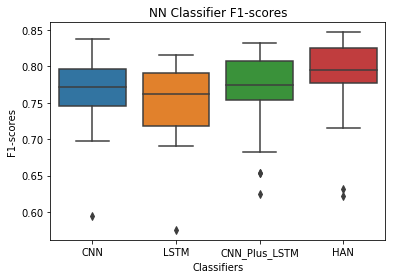

In [0]:
plt.clf()
fig1, ax1 = plt.subplots()
ax1.set_title("NN Classifier F1-scores")
sns.boxplot(x="variable", y="value", data=pd.melt(stats_df))
plt.xlabel("Classifiers")
plt.ylabel("F1-scores")
plt.show()